<a href="https://colab.research.google.com/github/Jun-prog/Machine-Learning/blob/master/%E6%B1%BA%E5%AE%9A%E6%9C%A8%E5%AD%A6%E7%BF%92%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6%E5%AD%A6%E3%81%B6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
pip install sklearn

SyntaxError: ignored

In [35]:
pip install graphviz

このノートブックは、決定木学習について学ぶことを目的としたものである。

疑問点　
1.   決定木学習における分類基準はどうやって決められているのか
2.   どう決めるのか
3.   この手法のメリット・デメリットは？






利用するテキスト・参考資料

決定木による分類基準を集計する
https://qiita.com/maskot1977/items/e5b142a59ab9a2e74608

scikit-learnの決定木系モデルを視覚化する方法（本家）
https://qiita.com/takahashi_yukou/items/5251bada1c3dc453c508


In [36]:
# iris のデータをインポート

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names) #　参考文献参照 コードとカテゴリまたはdtypeからカテゴリ型を作成します。one hot vector 的な感じ！！　

In [12]:
df # iris data 表示

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [19]:
print(df['species'])
print([list(iris.target_names).index(name) for name in df['species'].tolist()])
colors = [cmap((c)/ 3) for c in [list(iris.target_names).index(name) for name in df['species'].tolist()]]
print(colors)


0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: category
Categories (3, object): [setosa, versicolor, virginica]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[(0.2298057, 0.298717966, 0.753683153, 1.0), (0.2298057, 0.298717966, 0.753683153, 1.0), (0.2298057, 0.298717966, 0.753683153, 1.0), (0.2298057, 0.298717966, 0.753683153, 1.0), (0.2298057, 0.298717966, 0.753683153, 1.0), (0.2298057, 0.298717966, 0.753683153, 1.0

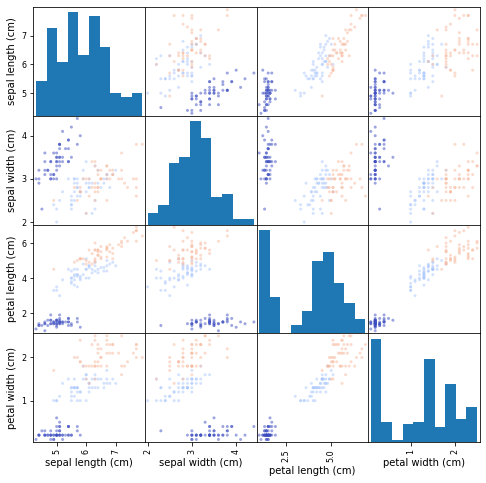

In [20]:
# scatter plot による概観 
# まずは scatter plot による概観をしてみましょうか。異なる species は異なる色で彩色しました。
cmap = plt.get_cmap("coolwarm")
colors = [cmap((c)/ 3) for c in [list(iris.target_names).index(name) for name in df['species'].tolist()]]
pd.plotting.scatter_matrix(df.dropna(axis=1)[df.columns[:]], figsize=(8, 8), color=colors) 
plt.show()


In [37]:
import pydotplus
from PIL import Image

# 決定木による分類と、分類基準の集計

features = df.columns[:4]
label = df['species']

criteria_distribution = {} # 分類基準の部分を抜き出して、集計するためのリスト
accumulated_feature_importances = np.zeros(len(df.columns)-1)

for time_of_learning in range(10): # 決定木による分類を１０回繰り返しました。
    df_train, df_test, label_train, label_test = train_test_split(df[features], label)
    clf = RandomForestClassifier(n_estimators=100) # １回の計算あたりの木の本数は１００本にしました。
    clf.fit(df_train, label_train)
    accumulated_feature_importances += clf.feature_importances_

    for estimator in clf.estimators_:
      tree.export_graphviz(estimator)
      for line in open("/content/sample_data/tree.dot"): #  "tree.dot" という名のテキストファイルが出力され、決定木の構造が記述される。
        matched = re.search('X\[.+?\n', line) 
        if matched:
          equation = matched.group(0).split("\\n")[0]
          numerals = re.findall('[0-9\.]+', line)

FileNotFoundError: ignored

# scikit-learnの決定木系モデルを視覚化する方法

https://qiita.com/takahashi_yukou/items/5251bada1c3dc453c508

この人の記事面白そう！！


In [40]:
"""
    決定木系モデルを視覚化する。
    Graphviz を用いて、決定木のモデルを視覚化する。
    決定木だけでなく、ランダムフォレストなど木構造のモデルに適用できる。

"""

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# モデルの木構造の視覚化に必要なパッケージ
from sklearn import tree
import pydotplus as pdp

import pandas as pd
import numpy as np

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

print(df.head(5))
print(iris.target)
print(iris.target_names)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
print(df.head(5))

# 学習データとテストデータを分ける

features = df.columns[:4]
label = df["species"]
print(features)
print(label)
print(df[features].head(5))
df_train, df_test, label_train, label_test = train_test_split(df[features], label)

clf = RandomForestClassifier(n_estimators=150)
clf.fit(df_train, label_train)
print("========================================================")
print("予測の精度")
print(clf.score(df_test, label_test))

# 試しに木の一つを視覚化する
estimators = clf.estimators_
file_name = "./tree_visualization.png"
dot_data = tree.export_graphviz(estimators[0], # 決定木オブジェクトを一つ指定する
                                out_file=None, # ファイルは介さずにGraphvizにdot言語データを渡すのでNone
                                filled=True, # Trueにすると、分岐の際にどちらのノードに多く分類されたのか色で示してくれる
                                rounded=True, # Trueにすると、ノードの角を丸く描画する。
                                feature_names=features, # これを指定しないとチャート上で特徴量の名前が表示されない
                                class_names=iris.target_names, # これを指定しないとチャート上で分類名が表示されない
                                special_characters=True # 特殊文字を扱えるようにする
                                )
graph = pdp.graph_from_dot_data(dot_data)
graph.write_png(file_name)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']
   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  species
0                5.1               3.5  ...               0.2   setosa
1                4.9               3.0  ...               0.

True

In [41]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

print(df.head(5))
print(iris.target)
print(iris.target_names)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
print(df.head(5))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']
   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  species
0                5.1               3.5  ...               0.2   setosa
1                4.9               3.0  ...               0.

In [42]:
features = df.columns[:4]
label = df["species"]
print(features)
print(label)
print(df[features].head(5))
df_train, df_test, label_train, label_test = train_test_split(df[features], label)

clf = RandomForestClassifier(n_estimators=150)
clf.fit(df_train, label_train)

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')
0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: category
Categories (3, object): [setosa, versicolor, virginica]
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
estimators = clf.estimators_
file_name = "./tree_visualization.png"
dot_data = tree.export_graphviz(estimators[0], # 決定木オブジェクトを一つ指定する
                                out_file=None, # ファイルは介さずにGraphvizにdot言語データを渡すのでNone
                                filled=True, # Trueにすると、分岐の際にどちらのノードに多く分類されたのか色で示してくれる
                                rounded=True, # Trueにすると、ノードの角を丸く描画する。
                                feature_names=features, # これを指定しないとチャート上で特徴量の名前が表示されない
                                class_names=iris.target_names, # これを指定しないとチャート上で分類名が表示されない
                                special_characters=True # 特殊文字を扱えるようにする
                                )
graph = pdp.graph_from_dot_data(dot_data)
graph.write_png(file_name)

True

これを基に、音楽の方も作ってみよう！！

まず、それぞれの感情別のcsvを一つにまとめる作業から
始めなければいけない。　pandas になれるために、pandas でやろう！！

参考文献


pandas.Categorical.from_codes

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.from_codes.html


```
dtype = pd.CategoricalDtype(['a', 'b'], ordered=True)
pd.Categorical.from_codes(codes=[0, 1, 0, 1], dtype=dtype)
[a, b, a, b]
Categories (2, object): [a < b]
```

pythonでランダムフォレストとアンサンブル学習まとめ
https://qiita.com/mshinoda88/items/8bfe0b540b35437296bd

なぜRandomForestは精度が高くなるのか？
RandomForestを含む決定木のような弱学習器は集団学習に向いている。
これはバイアスーバリアンスの観点から説明できます。
バイアスーバリアンス理論によると汎化誤差は次のように分解されます。

汎化誤差 = バイアス + バリアンス ＋ ノイズ

ここでバイアスは モデルの表現力 に由来する誤差、
バリアンスは データセットの選び方 に由来する誤差、
ノイズは 本質的に減らせない誤差 です。


対処したエラー


ImportError: No module named 'sklearn.cross_validation'の対処
https://www.haya-programming.com/entry/2018/12/04/052713

＝＞　　sklearnのバージョンの不一致が原因。

新しい書き方　　from sklearn.model_selection import cross_val_score